In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Load data from a chosen machine.

In [3]:
from utils import timesteps, train_percentage, getClientData, getTrainAndTestData

machine = 'Compressore 1'
data = getClientData(machine)
x_train, y_train, x_test, y_test, scaler = getTrainAndTestData(data)
train_size = x_train.shape[0]   # Number of training samples
timestamps = data.index.values  # Timestamps

Load model and weights.

In [4]:
from models import ncp, lstm

model, name = ncp()
weights_npz = np.load("weights_" + name + ".npz")
weights = [weights_npz[f"arr_{i}"] for i in range(len(weights_npz.files))]
model.set_weights(weights)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cf_c (CfC)                  (None, 5)                 316       
                                                                 
 dense (Dense)               (None, 32)                192       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.3

Predict and detect anomalies.

In [5]:
from utils import inverseData

# Predict
y_pred = model.predict(x_test)
y_pred_inverse, y_test_inverse = inverseData(scaler, y_pred, y_test)

# Compute the Mean Square Error (MSE) for each column and detect anomalies
y_err = np.power(y_test_inverse - y_pred_inverse, 2)
mse = np.mean(y_err, axis=0)
std_dev = np.std(y_err, axis=0)
anomaly_threshold = mse + 3 * std_dev
anomalies = y_err > anomaly_threshold

26/26 [==============================] - 0s 4ms/step


Plot the results.

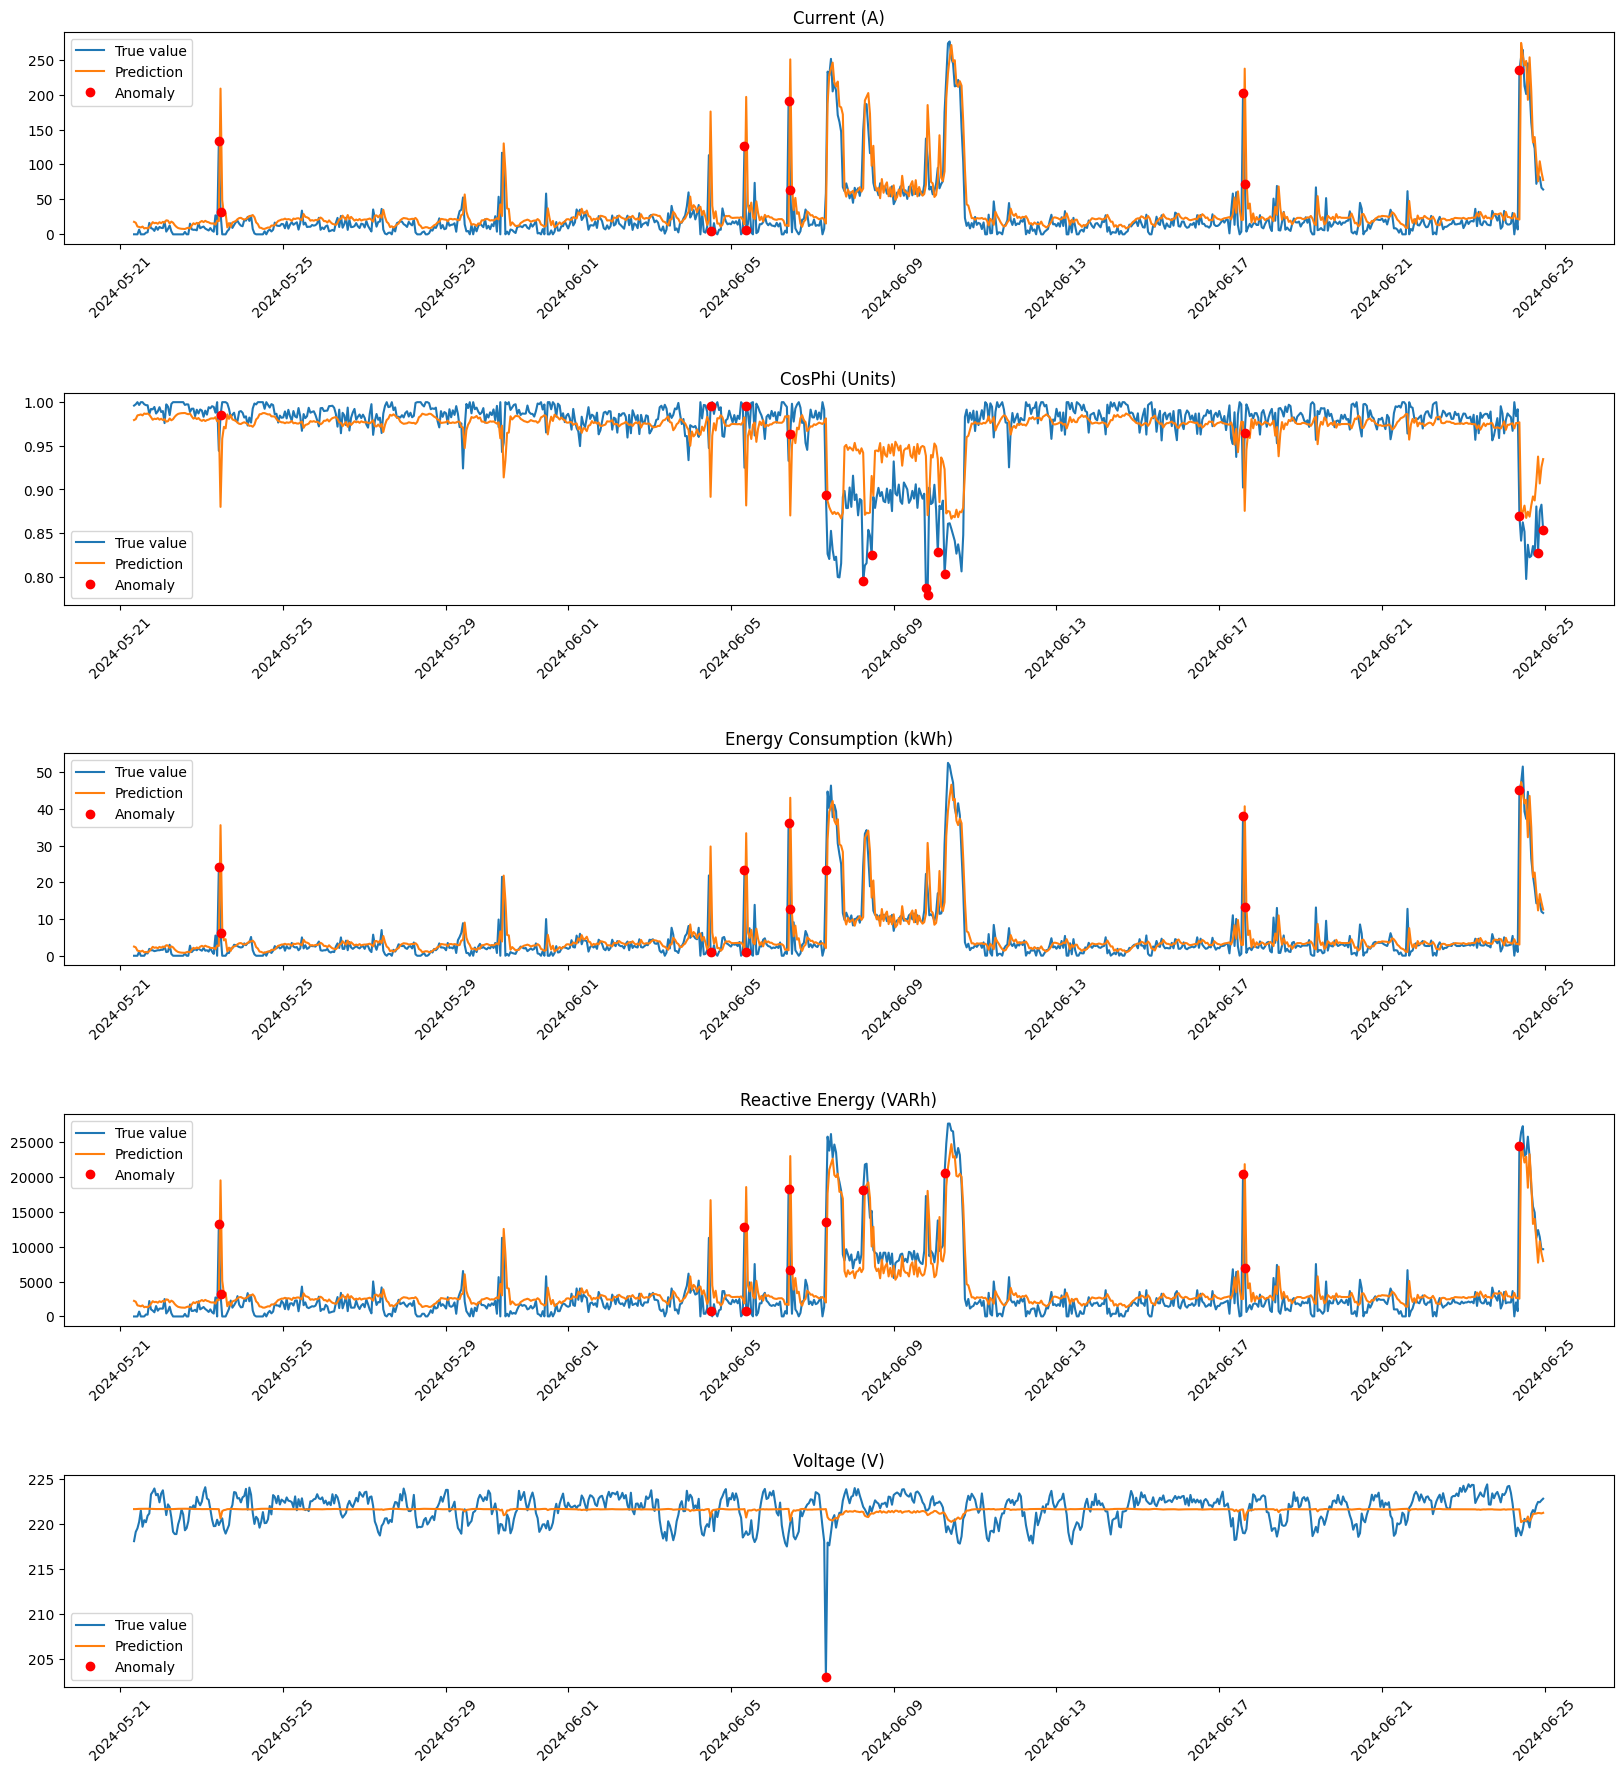

In [6]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(top=0.9375, hspace=0.7)

for i in range(len(data.columns)):
  plt.subplot(len(data.columns), 1, i + 1)
  plt.plot(timestamps[train_size+timesteps:], y_test_inverse[:, i], label='True value')
  plt.plot(timestamps[train_size+timesteps:], y_pred_inverse[:, i], label='Prediction')
  plt.plot(timestamps[train_size+timesteps:][anomalies[:, i]], y_test_inverse[:, i][anomalies[:, i]], 'ro', label='Anomaly')
  plt.xticks(rotation=45)
  plt.title(data.columns[i])
  plt.legend()
plt.subplots_adjust(hspace=0.7)
plt.show()

Save the detected anomalies to a multi-sheet XLSX file.

In [7]:
anomalies_ts = {data.columns[i]: timestamps[train_size+timesteps:][anomalies[:, i]] for i in range(len(data.columns))}

# Adjust timestamp format
anomalies_ts = {k: [str(v) for v in anomalies_ts[k]] for k in anomalies_ts}
anomalies_ts = {k: [v.replace("T", " ") for v in anomalies_ts[k]] for k in anomalies_ts} 
anomalies_ts = {k: [v.replace(".000000000", "") for v in anomalies_ts[k]] for k in anomalies_ts} 
anomalies_ts = {k: [v.replace("Z", "") for v in anomalies_ts[k]] for k in anomalies_ts}

# Create a DataFrame for each anomaly with timestamps, predicted values and true values
anomalies_df = {k: pd.DataFrame(anomalies_ts[k], columns=["Timestamp"]) for k in anomalies_ts}
anomalies_df = {k: anomalies_df[k].merge(pd.DataFrame(y_pred_inverse[:, i], columns=["Predicted value"]), left_index=True, right_index=True) for i, k in enumerate(anomalies_df)}
anomalies_df = {k: anomalies_df[k].merge(pd.DataFrame(y_test_inverse[:, i], columns=["True value"]), left_index=True, right_index=True) for i, k in enumerate(anomalies_df)}

# Save anomalies to XLSX
with pd.ExcelWriter("anomalies.xlsx") as writer:
  for k in anomalies_df:
    anomalies_df[k].to_excel(writer, sheet_name=k, index=False)